<a href="https://colab.research.google.com/github/santacruzAI/MLPhasesOfMatter/blob/main/Machine_Learning_Phase_Transitions_Final%2B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import random
!pip install numba
from numba import jit

# **Data Generation**

Here, we will perform the Metropolis-Hastings Algorithm to generate square lattices.

First, we calculate the square Hamiltonian.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
@jit
def get_energy(lattice):
  en = 0
  #Brute Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice)):
      if i>0:
        en -= lattice[i][j]*lattice[i-1][j]
      if i<len(lattice)-1:
        en -= lattice[i][j]*lattice[i+1][j]
      if j>0:
        en -= lattice[i][j]*lattice[i][j-1]
      if j<len(lattice)-1:
        en -= lattice[i][j] * lattice[i][j+1]
  return en

grid_size = 40 #The grid size.
starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
imList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
fig = plt.figure(figsize=(grid_size,grid_size))
for temp in temp_range:
  b = 1/(k*temp) #Computing the boltzmann constant (confirm).
  for start in range(starts):
    for sample in range(samples): 
      start_lat = np.array([[2*np.random.uniform() - 1 for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0] = 1.0
      lattice[start_lat<0] = -1.0
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])
      plt.imshow(lattice)
      tempList.append(temp)
len(sampleList), loopCount
fig = plt.figure()
ani = animation.ArtistAnimation(fig, imList, interval=50, blit=True,
                                repeat_delay=1000)

NameError: ignored

<Figure size 144x144 with 0 Axes>

In [ ]:
plt.show()

**Visualization of Ising Model Simulation**

 96%|█████████▋| 27/28 [00:02<00:00, 13.25it/s]


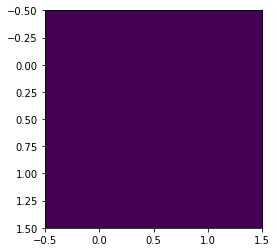

In [ ]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
fig, ax = plt.subplots()
@jit
def make_movie(sampleList):
  n = 3
  animation = VideoClip(make_frame, duration = n)
  animation.ipython_display(fps = len(sampleList)//n, loop = True, autoplay = True)

def make_frame(t):
    t = int(t/len(sampleList))
    ax.clear()
    ax.imshow(sampleList[t])
    return mplfig_to_npimage(fig)
  
make_movie(sampleList)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(timeList,enList)
plt.title("Energy vs Algorithmic Time")
count/total

## **Data Preprocessing**

In [ ]:
feature_matrix = np.array([features.flatten() for features in sampleList]) #Flatten lattice
np.random.shuffle(feature_matrix) #
end = 2 * len(feature_matrix) // 5
feature_train_matrix = feature_matrix[:-1*end]
feature_test_matrix = feature_matrix[-1*end:]
tempList2 = np.array([[temp] for temp in tempList])
tempList2_train = tempList2[:-1*end]
tempList2_test = tempList2[-1*end:]
Tc = 2.27
y_train = tempList2_train.copy()
y_train[tempList2_train>=Tc] = 1
y_train[tempList2_train<Tc] = 0
y_test = tempList2_test.copy()
y_test[tempList2_test>=Tc] = 1
y_test[tempList2_test<Tc] = 0
import pandas as pd
csv_train = pd.DataFrame(feature_train_matrix)
csv_train["y_train"] = y_train
csv_train = csv_train.to_csv("csv_train.csv")
csv_test = pd.DataFrame(feature_test_matrix)
csv_test["y_test"] = y_test
csv_test = csv_test.to_csv("csv_test.csv")
#from google.colab import files
#files.download("csv_train.csv")
#files.download("csv_test.csv")

## **Feedforward Neural Network for Lattice Phase Transitions**

In [ ]:
import torch.nn as nn #Super-class for PyTorch NNs
from torch.nn import Sigmoid
from torch.optim import Adam
import torch
from torch import Tensor
from torch import from_numpy
class LinearModel(nn.Module): 
    def __init__(self): #Define struct
        super(LinearModel, self).__init__()          
        self.fc_1 = nn.Linear(grid_size*grid_size, 100)    
        self.fc_2 = nn.Linear(100, 2)    
            
    def forward(self, X):    
        #output = self.norm(X)
        output = self.fc_1(X)
        output = nn.Sigmoid()(output)
        output = self.fc_2(output)
        output = nn.Sigmoid()(output)
        return output

In [ ]:
EPOCHS = 100

model = LinearModel()
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
y_train = torch.from_numpy(y_train)
y_train = y_train.type(torch.LongTensor)
feature_train_matrix = torch.from_numpy(feature_train_matrix)#.type(torch.DoubleTensor)
#print(np.shape(feature_train_matrix))
acc_list = []
ep_li = []
for ep in range(EPOCHS):
  acc = 0
  ep_li.append(ep)
  for i in range(len(y_train)):
    feature = feature_train_matrix[i:i+1].type(torch.FloatTensor)
    optimizer.zero_grad()
    out = model(feature)
    label = y_train[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    loss = criterion(out,label)
    loss.backward()
    optimizer.step()
  print("EPOCH",ep+1,"loss: ",round(loss.item(),2))
  print("Accuracy:",acc/len(y_train))  
  acc_list.append(acc/len(y_train))

This is the plot of the accuracies vs epochs.

In [ ]:
plt.plot(ep_li, acc_list)

Here, we evaluate the accuracy of our PyTorch model on our test data.

In [ ]:
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
model.eval()
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))
#csv_model = pd.DataFrame(model.state_dict())
#csv_model = csv_model.to_csv("model1.csv")
#files.download("model1.csv")
#torch.save(model,"./")

Here, we save training and testing data in csvs as well as saving the PyTorch model.

In [ ]:
from google.colab import files
#files.download("csv_train.csv")
#files.download("csv_test.csv")
from google.colab import drive
drive.mount('/content/gdrive')
#torch.save(model.state_dict(), '/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.994.pth')
torch.save(model.state_dict(), '/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.989.pth')

Here, we generate Triangular Lattices to evaluate our model against.

Here, we generate a hexagonal filter.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
grid_size = 40
grid = np.zeros((grid_size, grid_size)) > np.ones((grid_size, grid_size))
grid_length = grid_size - grid_size // 3
for i in range(grid_length//2):
  for j in range((grid_size-1)//3 - i,2*(grid_size-1)//3 + i):
    grid[i][j] = True
for i in range(grid_length//2,grid_length):
  k = i - grid_length//2
  init_left = (grid_size - 1)//3 - grid_length//2 
  init_right = 2*(grid_size - 1)//3 + grid_length//2
  for j in range(init_left+ k,init_right - k):
    grid[i][j] = True
plt.figure(figsize=(grid_size,grid_size))
plt.imshow(grid)
plt.show()

First, we generate triangular lattices, in the sense that it has a Triangular Hamiltonian. But we still generate square spins.

In [ ]:
from google.colab import files
files.upload() #Here, we reload our PyTorch model so that we don't need to retrain it each time.

In [ ]:
@jit
def get_energy(lattice):
  en = 0
  #Hexagonal Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice[i])):
      if(i>1 and j>2):
        en += lattice[i][j] * lattice[i-1][j-1] * lattice[i][j-2]
      if (i<len(lattice)-1 and j>2):
        en += lattice[i][j] * lattice[i][j-2] * lattice[i+1][j-1]
      if (i<len(lattice)-2 and j>1 and j<len(lattice)-1):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i+1][j-1]
      if (i<len(lattice) - 2 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i][j+2]
      if (i>1 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i][j+2] * lattice[i-1][j+1]
      if (i>1 and j > 1 and j<len(lattice) - 1):
        en += lattice[i][j] * lattice[i-1][j+1] * lattice[i-1][j-1]
  return en

grid_size = 40
starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      tempList.append(temp)

In [ ]:
sampleList[0]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(timeList,enList)
plt.title("Energy vs Algorithmic Time")
count/total

In [ ]:
feature_matrix = np.array([features.flatten() for features in sampleList]) #Flatten lattice
np.random.shuffle(feature_matrix) #
end = 2 * len(feature_matrix) // 5
feature_train_matrix = feature_matrix[:-1*end]
feature_test_matrix = feature_matrix[-1*end:]
tempList2 = np.array([[temp] for temp in tempList])
tempList2_train = tempList2[:-1*end]
tempList2_test = tempList2[-1*end:]
Tc = 2.27
y_train = tempList2_train.copy()
y_train[tempList2_train>=Tc] = 1
y_train[tempList2_train<Tc] = 0
y_test = tempList2_test.copy()
y_test[tempList2_test>=Tc] = 1
y_test[tempList2_test<Tc] = 0

In [ ]:
PATH = "/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.989.pth"
# Load
model = LinearModel()
model.load_state_dict(torch.load(PATH))
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
model.eval()
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    #loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))

Then, we generate Triangular Lattices in a hexagonal shape, but allow to try to flip the zero spins. (Zero spins just represent nothing; we are using them to outline the hexagons)

In [ ]:
@jit
def get_energy(lattice):
  en = 0
  #Hexagonal Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice[i])):
      if(i>1 and j>2):
        en += lattice[i][j] * lattice[i-1][j-1] * lattice[i][j-2]
      elif (i<len(lattice)-1 and j>2):
        en += lattice[i][j] * lattice[i][j-2] * lattice[i+1][j-1]
      elif (i<len(lattice)-2 and j>1 and j<len(lattice)-1):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i+1][j-1]
      elif (i<len(lattice) - 2 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i][j+2]
      elif (i>1 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i][j+2] * lattice[i-1][j+1]
      elif (i>1 and j > 1 and j<len(lattice) - 1):
        en += lattice[i][j] * lattice[i-1][j+1] * lattice[i-1][j-1]
  return en

starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      for i in range(grid_size):
        for j in range(grid_size):
          if not grid[i][j]:
            lattice[i][j] = 0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      tempList.append(temp)

In [ ]:
sampleList[0]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(timeList,enList)
plt.title("Energy vs Algorithmic Time")
count/total

In [ ]:
feature_matrix = np.array([features.flatten() for features in sampleList]) #Flatten lattice
np.random.shuffle(feature_matrix) #
end = 2 * len(feature_matrix) // 5
feature_train_matrix = feature_matrix[:-1*end]
feature_test_matrix = feature_matrix[-1*end:]
tempList2 = np.array([[temp] for temp in tempList])
tempList2_train = tempList2[:-1*end]
tempList2_test = tempList2[-1*end:]
Tc = 2.27
y_train = tempList2_train.copy()
y_train[tempList2_train>=Tc] = 1
y_train[tempList2_train<Tc] = 0
y_test = tempList2_test.copy()
y_test[tempList2_test>=Tc] = 1
y_test[tempList2_test<Tc] = 0

In [ ]:
PATH = "/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.989.pth"
# Load
model = LinearModel()
model.load_state_dict(torch.load(PATH))
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
model.eval()
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    #loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))

Now we generate Triangular Lattices, in a hexagonal shape. (The other elements in the lattice are 0s, no spins)

In [ ]:
@jit
def get_energy(lattice):
  en = 0
  #Hexagonal Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice[i])):
      if(i>1 and j>2):
        en += lattice[i][j] * lattice[i-1][j-1] * lattice[i][j-2]
      if (i<len(lattice)-1 and j>2):
        en += lattice[i][j] * lattice[i][j-2] * lattice[i+1][j-1]
      if (i<len(lattice)-2 and j>1 and j<len(lattice)-1):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i+1][j-1]
      if (i<len(lattice) - 2 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i+1][j+1] * lattice[i][j+2]
      if (i>1 and j<len(lattice) - 2):
        en += lattice[i][j] * lattice[i][j+2] * lattice[i-1][j+1]
      if (i>1 and j > 1 and j<len(lattice) - 1):
        en += lattice[i][j] * lattice[i-1][j+1] * lattice[i-1][j-1]
  return en

starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      for i in range(grid_size):
        for j in range(grid_size):
          if not grid[i][j]:
            lattice[i][j] = 0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        while lattice[flip_x][flip_y]==0:
          flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      tempList.append(temp)

In [ ]:
sampleList[0]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(timeList,enList)
plt.title("Energy vs Algorithmic Time")
count/total

In [ ]:
feature_matrix = np.array([features.flatten() for features in sampleList]) #Flatten lattice
np.random.shuffle(feature_matrix) #
end = 2 * len(feature_matrix) // 5
feature_train_matrix = feature_matrix[:-1*end]
feature_test_matrix = feature_matrix[-1*end:]
tempList2 = np.array([[temp] for temp in tempList])
tempList2_train = tempList2[:-1*end]
tempList2_test = tempList2[-1*end:]
Tc = 2.27
y_train = tempList2_train.copy()
y_train[tempList2_train>=Tc] = 1
y_train[tempList2_train<Tc] = 0
y_test = tempList2_test.copy()
y_test[tempList2_test>=Tc] = 1
y_test[tempList2_test<Tc] = 0

In [ ]:
PATH = "/content/gdrive/My Drive/SCAI ML Phases of Matter Implementation/model1.989.pth"
# Load
model = LinearModel()
model.load_state_dict(torch.load(PATH))
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)
feature_test_matrix = torch.from_numpy(feature_test_matrix)#.type(torch.DoubleTensor)
model.eval()
acc = 0
for i in range(len(y_test)):
    feature = feature_test_matrix[i:i+1].type(torch.FloatTensor)
    out = model(feature)
    label = y_test[i][0].unsqueeze(0)
    #print(label,out)
    if(label.item()==out.argmax().item()):
      acc+=1
    #loss = criterion(out,label)
#print(loss)
print(acc/len(y_test))

## **Triangular Lattice Regeneration**

Here, we try to generate data on square lattices.

In [ ]:
#Generate random grids of 1s and -1s, making sure they are unbalanced. Then calculate the energy of the current state. 
#Then pick a random particle in the lattice, and flip its sign. When you flip the spin, you have to calculate the energy of this new state again. 
#If it is less than the current energy, switch curr state to new state. If greater, apply the probability e^-(beta)(Ev-E_mu) = e^-(beta)(J)(summation of the product between the 
#flipped particle and its neighbors).
#Sample for many different temps
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
@jit
def get_energy(lattice):
  en = 0
  #Brute Neighbor Addition
  for i in range(len(lattice)):
    for j in range(len(lattice)):
      if i>0:
        en -= lattice[i][j]*lattice[i-1][j]
      if i<len(lattice)-1:
        en -= lattice[i][j]*lattice[i+1][j]
      if j>0:
        en -= lattice[i][j]*lattice[i][j-1]
      if j<len(lattice)-1:
        en -= lattice[i][j] * lattice[i][j+1]
  return en

grid_size = 2 #The grid size.
starts = 1 #For each temperature. 10
samples = 1 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 10 #100
tempList = []
sampleList = []
imList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
fig = plt.figure(figsize=(grid_size,grid_size))
for temp in temp_range:
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      sampleList.append(lattice)
      frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])
      plt.imshow(lattice)
      tempList.append(temp)
len(sampleList), loopCount
fig = plt.figure()
ani = animation.ArtistAnimation(fig, imList, interval=50, blit=True,
                                repeat_delay=1000)

## **Square Ice Model:**

## **Ising Lattice Gauge Theory:**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
!pip install tqdm
from tqdm import tqdm
@jit
def get_energy(lattice):
  en = 0
  #For each plaquette in lattice, add the product of its vertices' spins to en
  plaquettes = gen_plaquette(lattice) 
  for p in plaquettes: #[[1,-1],[-1,1]]
    en += p[0][0] * p[0][1] * p[1][0] * p[1][1]
  return en

@jit
def gen_plaquette(lattice):
  plaqs = []
  for i in range(len(lattice) - 2):
    for j in range(len(lattice[i]) - 2):
      plaqs.append(lattice[i:i+2, j:j+2])
  return plaqs

@jit
def get_energy_2(lattice):
  en = 0
  for i in range(len(lattice) - 2):
    for j in range(len(lattice)-2):
      en += lattice[i][j] * lattice[i + 1][j] * lattice[i][j + 1] * lattice[i + 1][j + 1]
  return en

grid_size = 16 #The grid size.
starts = 10 #For each temperature. 10
samples = 100 #The number of samples per start per temperature. 100
temp_range = np.linspace(1,3.7,27) #The range of temperatures from 1 to 3.7
therm_steps = 100 #100
tempList = []
sampleList = []
frames = []
imList = []
k = (1.38064852)/(10**23)
#b = 0.7 #This is our beta*J value. b = 1/kT
count = 0
total = 0
loopCount = 0
fig = plt.figure(figsize=(grid_size,grid_size))
for temp_i in tqdm(range(len(temp_range))):
  temp = temp_range[temp_i]
  b = 1/(k*temp)
  for start in range(starts):
    for sample in range(samples):
      loopCount+=1
      start_lat = np.array([[np.random.exponential() for a in range(grid_size)] for count2 in range(grid_size)])
      lattice = np.zeros((grid_size,grid_size))
      lattice[start_lat>=0.4] = 1.0
      lattice[start_lat<0.4] = -1.0
      if list(lattice.flatten()).count(1.)/(grid_size**2) > 0.5:
        count+=1#To ensure largely unbalanced  
        total += 1
      else:
        total += 1
      enList = []
      timeList = []
      time = 0  
      for therm_step in range(therm_steps):
        curr_en = get_energy_2(lattice)
        flip_x,flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
        state_v = lattice.copy()
        state_v[flip_x][flip_y] *=-1
        v_en = get_energy_2(state_v)
        p_uv = 1 if v_en<curr_en else np.exp(-b*(v_en - curr_en))
        timeList.append(time)
        time += 1
        if np.random.random()<p_uv:
          lattice = state_v.copy()
        enList.append(get_energy(lattice))
      if random.random()>0.5:
        sampleList.append(lattice)
      tempList.append(temp)

In [ ]:
import cv2
duration = 60
fps = len(sampleList)//duration
out = cv2.VideoWriter('gauge_lattice.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (grid_size, grid_size), False)
for i in range(len(sampleList)):
  frame = np.uint8(255 * sampleList[i])
  out.write(frame)
out.release()

In [ ]:
from google.colab import files
files.download('gauge_lattice.mp4')

Here, a Convolutional Neural Network on the Ising Gauge Theory Lattice, ideally to produce near 100% accuracy.

Preprocessing: Here, we convert the 16x16 lattices generated into a tensor of shape 16x16x2, with each of the two values doing one-hot encoding of each spin.


In [ ]:
import torch
pos_mat = lattice>0
neg_mat = lattice<0
total_li = []
def bool_bin(bool):
  return 1 if bool else 0
for i in range(len(pos_mat)):
  total_li.append([])
  for j in range(len(pos_mat[i])):
    total_li[i].append([bool_bin(pos_mat[i][j]), bool_bin(neg_mat[i][j])])
total_np = np.array(total_li)

## **Generating New Test Sets: **